In [29]:
import pandas as pd

# Data
df_partition = pd.read_csv("average_network_partition.csv", index_col=[0])
df_individuals_raw = pd.read_csv('../networks/data/global_before_1700.csv', index_col=[0])

df_partition['community'] = df_partition['community'].astype(int)
mapping = {0:'Human Domain', 1:'Natural Domain', 2:'Abstract Domain'}
df_partition['domain'] = df_partition['community'].apply(lambda x: mapping.get(x))

df_individuals_raw = df_individuals_raw[df_individuals_raw['birthyear']>=1600]

In [30]:
df_individuals = df_individuals_raw[['wikidata_id', 'individual_name', 'region_name', 'meta_occupation']].copy()
df_individuals['meta_occupation']  = df_individuals['meta_occupation'].apply(lambda x: x.split(' |'))
df_individuals = df_individuals.explode('meta_occupation')
df_individuals = df_individuals.rename(columns={'meta_occupation':'node'})
df_individuals = pd.merge(df_individuals, df_partition, on = 'node')
df_individuals = df_individuals.drop_duplicates(['wikidata_id', 'domain'], keep='first')

In [31]:
for domain in df_individuals['domain'].unique():
    print(domain)
    df_domain = df_individuals[df_individuals['domain']==domain]
    df_domain = df_domain[['wikidata_id', 'node']].drop_duplicates()
    print(df_domain['node'].value_counts().head(3))

Human Domain
theologian     2177
historian      1040
philosopher     470
Name: node, dtype: int64
Natural Domain
geographer    318
botanist      286
anatomist     104
Name: node, dtype: int64
Abstract Domain
mathematician    295
astronomer       241
musicologist     110
Name: node, dtype: int64


In [32]:
# # Remove those for original graph with original datasets
# bigger_regions = {'Central Europe':'Eastern Europe', 
#                   'Slav world':'Eastern Europe',
#                   'Balkans':'Eastern Europe',
#                   'Korea':'Asia',
#                   'Chinese world':'Asia', 
#                   'Japan':'Asia', 
#                   'Indian world':'Asia',
#                   'South East Asia':'Asia', 
#                   'Greek World':'Ancient Mediterranean', 
#                   'Latin World':'Ancient Mediterranean',
#                   'Arabic world':'MENA',
#                   'Persian world':'MENA',
#                   'Ottoman Turkey':'MENA',
#                   'Spain':'Iberian Peninsula',
#                   'Portugal':'Iberian Peninsula'}


bigger_regions = {'Central Europe':'Europe', 
                    'Slav world':'Europe',
                    'France':'Europe',
                    'Italy':'Europe',
                    'Nordic countries':'Europe',
                    'German world':'Europe',
                    'Low countries':'Europe',
                    'British Islands':'Europe',
                    'Balkans':'Europe',
                    'Korea':'Non-Europe',
                    'Chinese world':'Non-Europe', 
                    'Japan':'Non-Europe', 
                    'Indian world':'Non-Europe',
                    'South East Asia':'Non-Europe', 
                    'Greek World':'Non-Europe', 
                    'Latin World':'Non-Europe',
                    'Arabic world':'Non-Europe',
                    'Persian world':'Non-Europe',
                    'Ottoman Turkey':'Non-Europe',
                    'Spain':'Europe',
                    'Portugal':'Europe'}

df_individuals['region_name'] = df_individuals['region_name'].apply(lambda x: bigger_regions.get(x, x))
set(df_individuals['region_name'])

df_individuals['region_name'] = df_individuals['region_name'].apply(lambda x: bigger_regions.get(x, x))
set(df_individuals['region_name'])


{'Europe', 'Non-Europe'}

In [33]:
# Group the data by region and domain and calculate the percentages
df_country = df_individuals.groupby(['region_name', 'domain'])['wikidata_id'].count().rename('count_domains').reset_index()
df_country = df_country.groupby(['region_name', 'domain']).agg({'count_domains': 'sum'})
df_country = df_country.reset_index()

# Create a DataFrame with all possible combinations of region_name and domain
all_regions = df_country['region_name'].unique()
all_domains = df_country['domain'].unique()
all_combinations = [(r, d) for r in all_regions for d in all_domains]
df_all_combinations = pd.DataFrame(all_combinations, columns=['region_name', 'domain'])

merged_data = pd.merge(df_all_combinations, df_country, on=['region_name', 'domain'], how='left')
merged_data['count_domains'] = merged_data['count_domains'].fillna(0)

df_country = merged_data.copy()
df_country = df_country.set_index('region_name')


df_country['percent'] = (df_country['count_domains'] / df_country.groupby('region_name')['count_domains'].transform('sum')) * 100
#df_country['percent'] = round(df_country['percent'], 1)
df_country = df_country.reset_index()


# Calculate the mean percentage for each domain
mean_percentages = df_country.groupby('domain')['percent'].mean()
mean_percentages.reset_index()['percent'].sum()

import matplotlib.pyplot as plt

# Create a new column for the difference from the mean
df_country['difference_from_mean'] = df_country.apply(lambda row: row['percent'] - mean_percentages[row['domain']], axis=1)
df_country


,region_name,domain,count_domains,percent,difference_from_mean
0,Europe,Abstract Domain,688,12.656365,-4.291287
1,Europe,Human Domain,3853,70.879323,0.705148
2,Europe,Natural Domain,895,16.464312,3.586138
3,Non-Europe,Abstract Domain,48,21.238938,4.291287
4,Non-Europe,Human Domain,157,69.469027,-0.705148
5,Non-Europe,Natural Domain,21,9.292035,-3.586138


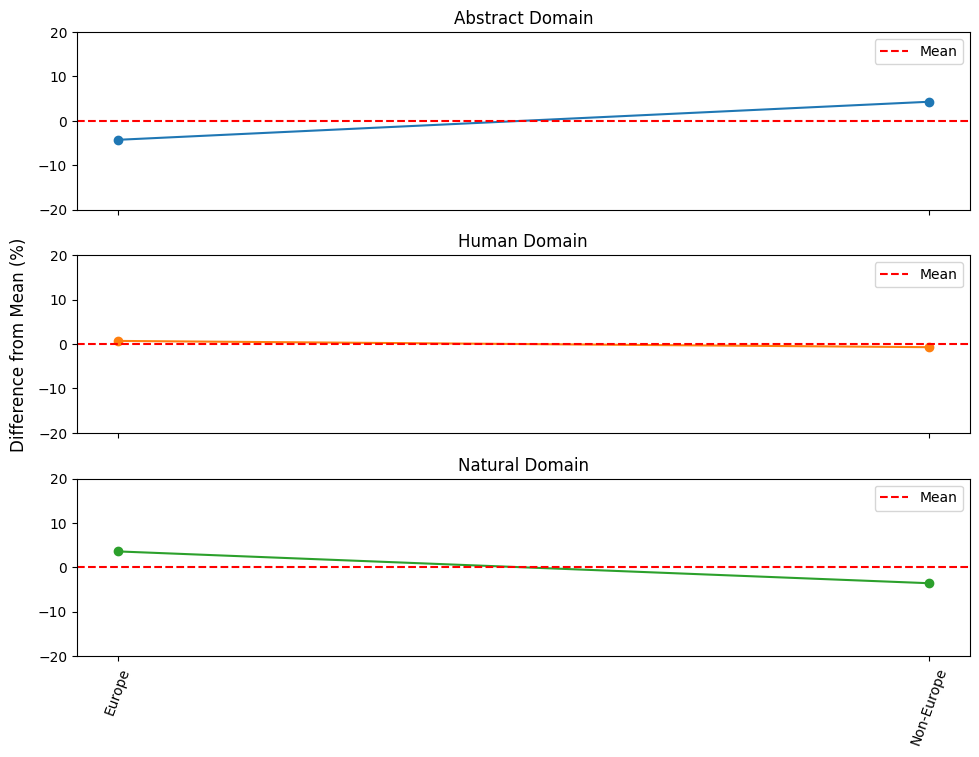

In [34]:


# Create a single graph with three subplots stacked on top of each other
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)  # Adjust the height (7) as needed

# List of unique domains
domains = df_country['domain'].unique()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Choose nicer colors

for i, domain in enumerate(domains):
    domain_data = df_country[df_country['domain'] == domain]
    
    axs[i].plot(domain_data['region_name'], domain_data['difference_from_mean'], marker='o', linestyle='-', color=colors[i])
    axs[i].axhline(y=0, color='r', linestyle='--', label='Mean')
    #axs[i].set_ylabel('Difference from Mean (%)')
    axs[i].set_title(f'{domain}')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].legend(loc='upper right')
    
    # Set the y-axis limits to -100 to 100
    axs[i].set_ylim(-20, 20)
    
    axs[i].legend()
    axs[i].grid(False)

# Add a unique ylabel
fig.supylabel('Difference from Mean (%)')

plt.tight_layout()
plt.xticks(rotation=70)
plt.show()

In [35]:
df_country[df_country['domain']=='Natural Domain'].sort_values('difference_from_mean', ascending=False)

,region_name,domain,count_domains,percent,difference_from_mean
2,Europe,Natural Domain,895,16.464312,3.586138
5,Non-Europe,Natural Domain,21,9.292035,-3.586138


In [36]:
df_stats = df_country[['region_name', 'domain', 'percent']].copy()
domain_variance = df_stats.groupby('domain')['percent'].std()
domain_variance

domain
Abstract Domain    6.068796
Human Domain       0.997230
Natural Domain     5.071565
Name: percent, dtype: float64

## For time

In [37]:
import numpy as np
df_individuals_time = df_individuals_raw[['wikidata_id', 'individual_name', 'birthyear', 'meta_occupation']].copy()
df_individuals_time['century'] = df_individuals_time['birthyear'].apply(lambda x : np.round(np.array(x) / 200) * 200
)


df_individuals_time['meta_occupation']  = df_individuals_time['meta_occupation'].apply(lambda x: x.split(' |'))
df_individuals_time = df_individuals_time.explode('meta_occupation')
df_individuals_time = df_individuals_time.rename(columns={'meta_occupation':'node'})
df_individuals_time = pd.merge(df_individuals_time, df_partition, on = 'node')
df_individuals_time = df_individuals_time.drop_duplicates(['wikidata_id', 'domain'], keep='first')


# Group the data by region and domain and calculate the percentages
df_time = df_individuals_time.groupby(['century', 'domain'])['wikidata_id'].count().rename('count_domains').reset_index()
df_time = df_time.groupby(['century', 'domain']).agg({'count_domains': 'sum'})
df_time = df_time.reset_index()
df_time = df_time[df_time['century']>=-500]


# Create a DataFrame with all possible combinations of region_name and domain
all_times = df_time['century'].unique()
all_domains = df_time['domain'].unique()
all_combinations = [(r, d) for r in all_times for d in all_domains]
df_all_combinations = pd.DataFrame(all_combinations, columns=['century', 'domain'])

merged_data = pd.merge(df_all_combinations, df_time, on=['century', 'domain'], how='left')
merged_data['count_domains'] = merged_data['count_domains'].fillna(0)

df_time = merged_data.copy()
df_time = df_time.set_index('century')


df_time['percent'] = (df_time['count_domains'] / df_time.groupby('century')['count_domains'].transform('sum')) * 100
#df_country['percent'] = round(df_country['percent'], 1)
df_time = df_time.reset_index()


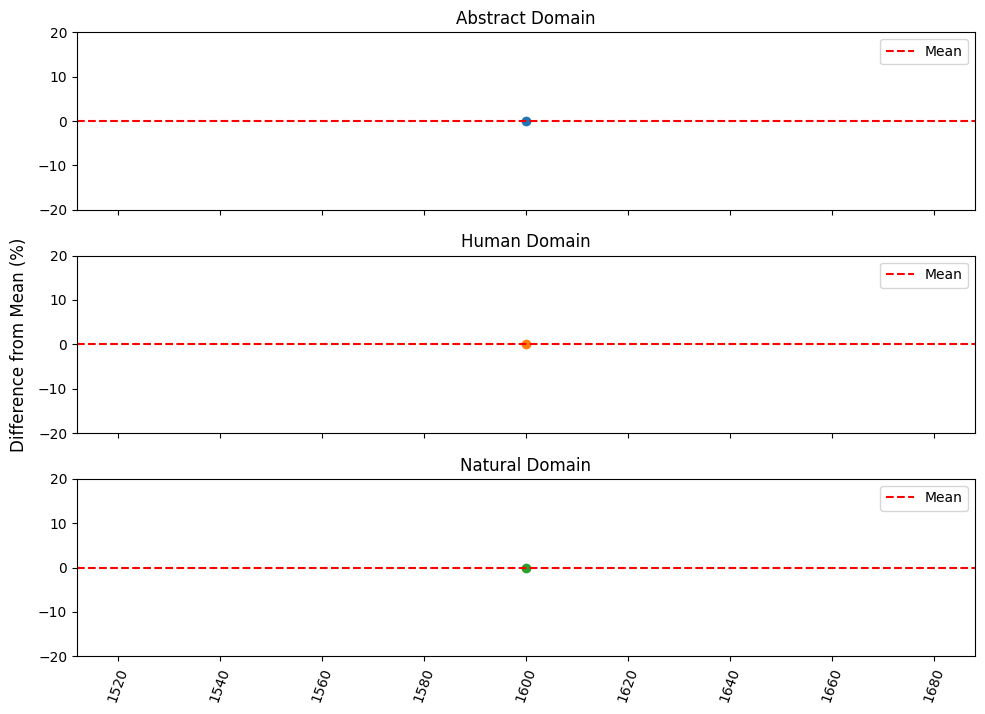

In [38]:
# Calculate the mean percentage for each domain
mean_percentages = df_time.groupby('domain')['percent'].mean()
mean_percentages.reset_index()['percent'].sum()

import matplotlib.pyplot as plt

# Create a new column for the difference from the mean
df_time['difference_from_mean'] = df_time.apply(lambda row: row['percent'] - mean_percentages[row['domain']], axis=1)


# Create a single graph with three subplots stacked on top of each other
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)  # Adjust the height (7) as needed

# List of unique domains
domains = df_time['domain'].unique()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Choose nicer colors

for i, domain in enumerate(domains):
    domain_data = df_time[df_time['domain'] == domain]
    
    axs[i].plot(domain_data['century'], domain_data['difference_from_mean'], marker='o', linestyle='-', color=colors[i])
    axs[i].axhline(y=0, color='r', linestyle='--', label='Mean')
    #axs[i].set_ylabel('Difference from Mean (%)')
    axs[i].set_title(f'{domain}')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].legend(loc='upper right')
    
    # Set the y-axis limits to -100 to 100
    axs[i].set_ylim(-20, 20)
    
    axs[i].legend()
    axs[i].grid(False)

# Add a unique ylabel
fig.supylabel('Difference from Mean (%)')

plt.tight_layout()
plt.xticks(rotation=70)
plt.show()

### Qualitative Check for the Low Countries

In [39]:
df_individuals

,wikidata_id,individual_name,region_name,node,community,domain
0,Q6240116,John Howe,Europe,theologian,0,Human Domain
1,Q6261137,John Trapp,Europe,theologian,0,Human Domain
2,Q185832,Emmanuel Swedenborg,Europe,theologian,0,Human Domain
3,Q310439,George Fox,Europe,theologian,0,Human Domain
4,Q5077323,Charles Edwards,Europe,theologian,0,Human Domain
...,...,...,...,...,...,...
5657,Q5014202,Hermanus Angelkot junior,Europe,pharmacologist,1,Natural Domain
5658,Q117042,Johann Jakob Wepfer,Europe,pharmacologist,1,Natural Domain
5659,Q73983,Johann Schröder,Europe,pharmacologist,1,Natural Domain
5660,Q60377771,Johann Francke,Europe,pharmacologist,1,Natural Domain


In [40]:
df_fin_ind = pd.merge(df_individuals_time[['wikidata_id', 'century', 'domain', 'node']], df_individuals[['wikidata_id', 'region_name']])
#df_fin_ind = df_fin_ind[df_fin_ind['region_name']=='Low countries']
df_fin_ind = df_fin_ind.groupby(['region_name', 'century','domain', 'node'])['wikidata_id'].count().reset_index()
df_fin_ind = df_fin_ind[df_fin_ind['domain']=='Natural Domain']
df_fin_ind = df_fin_ind.sort_values('wikidata_id', ascending=False)
df_fin_ind.head(30)



,region_name,century,domain,node,wikidata_id
19,Europe,1600.0,Natural Domain,geographer,306
17,Europe,1600.0,Natural Domain,botanist,277
15,Europe,1600.0,Natural Domain,anatomist,104
23,Europe,1600.0,Natural Domain,zoologist,86
18,Europe,1600.0,Natural Domain,chemist,79
20,Europe,1600.0,Natural Domain,geologist,27
33,Non-Europe,1600.0,Natural Domain,geographer,12
32,Non-Europe,1600.0,Natural Domain,botanist,9
16,Europe,1600.0,Natural Domain,art theorist,8
22,Europe,1600.0,Natural Domain,pharmacologist,5
